## FUTURES Simulation  

#### The Patch Growth Algorithm PGA ([r.futures.pga](https://grass.osgeo.org/grass82/manuals/addons/r.futures.pga.html)) simulates developed land changes based on development potential and land demand. Development potential is updated at each step in the iteration which updates development potential for the next step.

#### This notebook is used to compute FUTURES simulations under three scenarios set in the POTENTIAL submodel (see futures_potential.ipynb):
- inclusion classic predictors of development (including land cover data, slope, location of roads)
- inclusion of classic predictors and core-district zoning
- inclusion of classic predictors and sub-district zoning

###### Usage note: this script relies on outputs from futures_preprocessing.ipynb, futures_potential.ipynb, and futures_demand.ipynb


Initialize GRASS notebook and add required extensions

In [1]:
# Set up GRASS environment
import os
import csv
from IPython.display import Image
from helper import show_interactively, show
import grass.script as gs
# had to add shell = True to helper.py for this to work
from helper import initialize_GRASS_notebook
initialize_GRASS_notebook(binary='grass83',
                          grassdata="D:\\grassdata", location="FUTURES_zoning_prelim",
                          mapset="input")

Set GRASS region and mask to the Central Pines Regional Council

In [3]:
!g.region vector=central_pines_regional_council@input res=30
!r.mask raster=sa_counties@input

All subsequent raster operations will be limited to the MASK area. Removing
or renaming raster map named 'MASK' will restore raster operations to
normal.


Helper function used to save predictors selected by the POTENTIAL model

In [2]:
def get_pred(file_name):
    file = open(file_name)
    csvreader = csv.reader(file)
    pred = []
    # remove first three columns because they are always ID, Intercept, and devpressure
    pred = next(csvreader)[3:]
    file.close()
    return pred

Set common variables to be used throughout the Notebook

In [17]:
train_years = [2001, 2004, 2006, 2008, 2011]
validate_years = [2013, 2016, 2019, 2021]

# subregions
subregion = 'sa_counties@input'
dev_start = 'urban_2001@input'
dev_end = 'urban_2011@input'
dev_pressure='devpressure_2011@input'
# number of years to simulate after 2011
num_year = 10

# range of calibration values to test
discount_factor = [0.2, 0.5, 0.8]
compactness_mean = [0.3, 0.5, 0.8]
compactness_range = [0.05, 0.2]

# number of processors
nprocs = 5

### Calibration

Compute FUTURES patch calibration ([r.futures.calib](https://grass.osgeo.org/grass82/manuals/addons/r.futures.calib.html)) to select best patch size and compactness values for computing futures simulations.  

- discount_factor is used to alter simulated patch size to match observed patterns
- compactness_mean and compactness_range are used to match the distribution of observed compactness

In [6]:
def calibrate(potential, demand, calib, patches, rep):
    predictors = '@input,'.join(get_pred(potential))
    gs.run_command('r.futures.calib', development_start=dev_start, development_end=dev_end, num_steps=num_year,
                subregions=subregion, patch_sizes=patches, patch_threshold=1800, flags='s',
                repeat=rep, calibration_results=calib, nprocs=nprocs,
                predictors=predictors,
                devpot_params=potential, development_pressure=dev_pressure,
                n_dev_neighbourhood=37, development_pressure_approach='gravity', gamma=0.5, scaling_factor=0.1,
                demand=demand, discount_factor=discount_factor, compactness_mean=compactness_mean,
                compactness_range=compactness_range, num_neighbors=4, seed_search='probability', random_seed=1, overwrite=True)

Calibrate patch compactness and size values based on baseline potential parameters (no zoning)

###### Another method could be to calibrate for each group of potential parameters (no zoning, core district zoning, sub-district zoning) but for comparability between runs I kept compactness and patch values the same.

In [6]:
calibrate('results\\potential.csv', 'results\\demand.csv', 'results\\calib.csv', 'results\\patches.csv', 5)

### Run FUTURES Simulation

To compute FUTURES simulation, I used [r.futures.parallelpga](https://grass.osgeo.org/grass82/manuals/addons/r.futures.parallelpga.html) in order to compute in parallel (speed up runtime). Alternatively, I could have followed the method outlined [here ](https://github.com/ncsu-geoforall-lab/grass-workshop-gis-week-2023/blob/main/02_FUTURES_case_study.ipynb) and used [r.futures.simulation](https://grass.osgeo.org/grass82/manuals/addons/r.futures.simulation.html) and computed simulations for each county individually. However, given my small study area I choose to simulate across all counties to limit edge effects.

Create python file used to run FUTURE simulation when given GRASS mapset and output from the POTENTIAL submodel.  

###### Note: creating python file to run simulation because of bug/unknown error when running in Jupyter Notebook

In [91]:
%%writefile simulation.py
import sys
import grass.script as gs
import csv

mapset, potential = sys.argv[1:3]
gs.run_command("g.mapset", mapset=mapset, flags='c')
gs.run_command("g.mapsets", mapset="input", operation="add")
gs.run_command("g.region", vector="central_pines_regional_council@input", res=30)
gs.run_command("r.mask", raster="sa_counties@input", overwrite=True)
calib = "C:\\Users\\malawrim\\Documents\\GitHub\\FUTURES_zoning_prelim\\results\\calib.csv"
with open(calib) as f:
    factor, comp_mean, comp_range = f.readlines()[1].split(',')[:3]

def get_pred(file_name):
    file = open(file_name)
    csvreader = csv.reader(file)
    pred = []
    # remove first three columns because they are always ID, Intercept, and devpressure
    pred = next(csvreader)[3:]
    file.close()
    return pred

predictors = get_pred(potential)

gs.run_command(
    "r.futures.parallelpga",
    subregions='sa_counties@input',
    developed='urban_2011@input',
    num_steps=10,
    predictors=predictors,
    devpot_params=potential,
    development_pressure='devpressure_2011@input',
    n_dev_neighbourhood=37,
    development_pressure_approach='gravity',
    gamma=0.5,
    scaling_factor=0.1,
    demand="C:\\Users\\malawrim\\Documents\\GitHub\\FUTURES_zoning_prelim\\results\\demand.csv",
    discount_factor=disc_factor,
    compactness_mean=comp_mean,
    compactness_range=comp_range,
    patch_sizes="C:\\Users\\malawrim\\Documents\\GitHub\\FUTURES_zoning_prelim\\results\\patches.csv",
    num_neighbors=4,
    seed_search='probability',
    random_seed=42,
    output='test_final',
    output_series='test_step',
    nprocs=2,
    repeat=2,
    overwrite=True)
gs.run_command("r.mask", flags="r")

Overwriting simulation.py


### Compute simulations for each POTENTIAL parameterization method (no zoning, core district zoning, and sub-district zoning)

In [90]:
mapset = 'base'
# should be "C:\\Users\\malawrim\\Documents\\GitHub\\FUTURES_zoning_prelim\\results\\potential.csv"
potential = os.path.join(os.getcwd(), "results\\potential.csv")
!python simulation.py {mapset} {potential}

In [92]:
mapset = 'core'
potential = os.path.join(os.getcwd(), "results\\potential_core.csv")
!python simulation.py {mapset} {potential}

Mapset <input> already in the path
Search path not modified
All subsequent raster operations will be limited to the MASK area. Removing
or renaming raster map named 'MASK' will restore raster operations to
normal.
Running simulation 2/2
Running simulation 1/2
Read random seed from random_seed option: 2
   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 100
Raster map <test_step_run2_01> created
Raster map <test_step_run2_02> created
Raster map <test_step_run2_03> created
Raster map <test_step_run2_04> created
Raster map <test_step_run2_05> created
Raster map <test_step_run2_06> created
Raster map <test_step_run2_07> created
Raster map <test_step_run2_08> created
Raster map <test_step_run2_09> created
Raster map <test_step_run2_10> created
Raster map <test_final_run2> created
Read random seed from random_seed option: 1
   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 100
Raster map <test_step_run1_01> created
Raster map <test_step_run1_02> created
R

In [ ]:
mapset = 'sub'
potential = os.path.join(os.getcwd(), "results\\potential_sub.csv")
!python simulation.py {mapset} {potential}

### Calculate FUTURES Results  

After successfully running FUTURES simulations, generate accuracy results and development probability rasters  

See futures_postprocess Notebook for explanation of results

Create a file used to reclassify development results

In [ ]:
%%writefile reclass.txt
-1 0 = 0
1 thru 100 = 1
* = 0

Import functions from validation.py (adapted from [r.futures.validation](https://grass.osgeo.org/grass82/manuals/addons/r.futures.validation.html) written by Anna Petrasova)

In [95]:
import validation
import json
import pickle

Compute validation metrics including hits, misses, quantity and allocation disagreement 

In [102]:
def calc_results(mapset, file):
    # to get hits, misses, etc.
    metrics = []
    !g.mapset mapset={mapset}
    n = 50
    # validation.compute replaces gs.read_command('r.futures.validation', simulated=f'final_run{i}_reclass', reference='urban_2021@input', original='urban_2001@input', format='json'))
    for i in range(1, n + 1):
        !r.reclass input=final_run{i} output=final_run{i}_reclass rules=reclass.txt --o
        cats, results = validation.compute('urban_2021@input', f'final_run{i}_reclass', 'urban_2001@input')
        # **results passes the key-value pairs from results dictionary as named arguments to the function print_results
        # very cool
        metrics.append(validation.print_results('json', cats, **results))
    # get probabilty raster for 2021
    # removed ,weights=[0.02] * 50,
    gs.run_command(
        "r.series",
        input=[f"final_run{seed}_reclass" for seed in range(1, 51)],
        output="probability",
        method="sum"
    )
    with open(file, "wb") as pf:
    pickle.dump(metrics, pf)

Calculate results for each POTENTIAL scenario

In [103]:
calc_results('sub', "metrics_sub")
calc_results('core', "metrics_core")
calc_results('base', "metrics_base")

Mapset switched. Your shell continues to use the history for the old mapset


(Optional) Run this section to reclassify each year (step of simulation) to a binary (developed/not developed) raster and create probability of development raster for each year in the simulation

In [ ]:
for step in range(1,11):
    for seed in range(1, 51):
        gs.run_command(
            "r.reclass",
            input=f"step_run{seed}_{step}",
            output=f"step_run{seed}_{step}_reclass",
            rules="reclass.txt",
        )
    # compute probabilty of development for each year
    gs.run_command(
        "r.series",
        input=[f"step_run{seed}_{step}_binary" for seed in range(1, 51)],
        output="probability",
        method="sum",
        weights=[0.1] * 10,
        nprocs=2,
    )

### Explanation of Results  

Across all POTENTIAL parameterization methods we see the greatest probability of development in Wake County. Additionally, we see sprawling growth patterns from Wake County to surrounding Durham and Johnson counties. Between methods, there is greater variability in predicted growth patterns in less developed counties. For example, in Chatham County the probability of development surrounding the two larger cities, Pittsboro (eastern side of the county) and Siler City (western side) varies between methods. The base method predicts small amounts of development in both cities, the core method predicts slightly more in both cities, while the sub method predicts no (very low) amounts of development in Siler City and slightly more development in Pitsboro.

For accuracy and validation metrics see futures_postprocess Notebook.

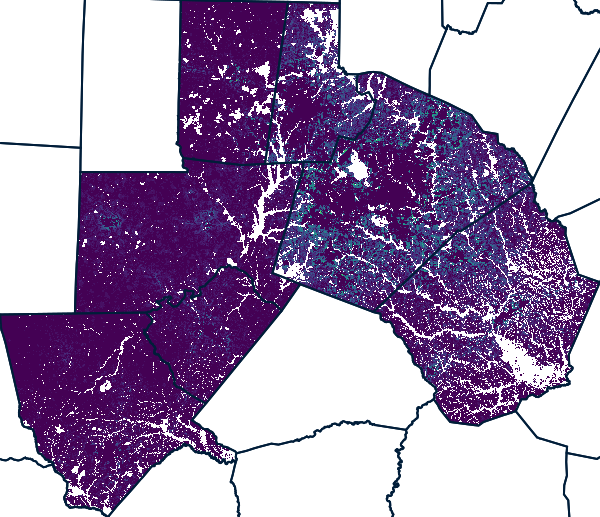

In [4]:
show("probability@base")

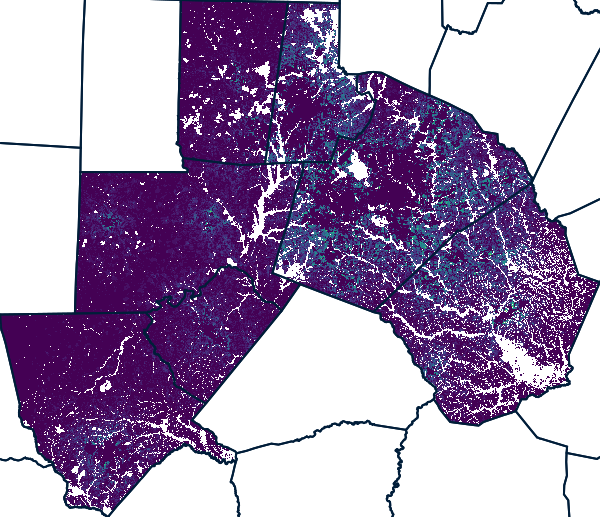

In [2]:
show("probability@core")

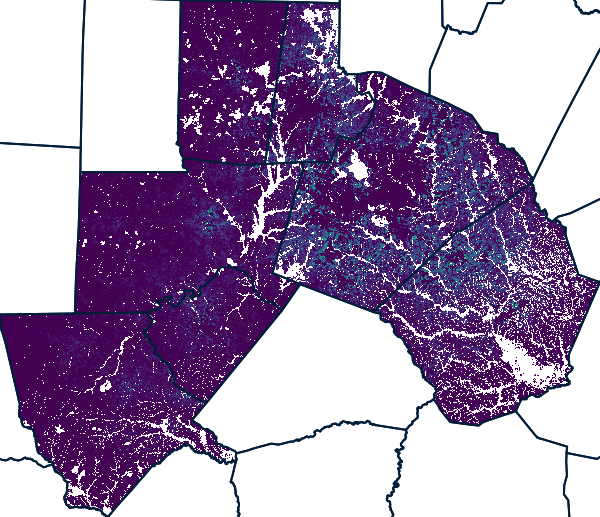

In [3]:
show("probability@sub")